# Comparing 2DTM scoring metrics

This notebook demonstrates how the three scoring metrics implemented in Leopard-EM work by visualizing the steps along each process.
Data used in this notebook are hosted on [Zenodo](https://zenodo.org/records/15426374).

In [ ]:
"""2DTM scoring metrics."""

import matplotlib as mpl
import matplotlib.pyplot as plt
import mrcfile
import numpy as np
import torch
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from leopard_em.analysis.gev_fit_metric import fit_gev_to_zscore
from leopard_em.analysis.pvalue_metric import (
    probit_transform_torch,
    estimate_anisotropic_gaussian,
    anisotropic_pvalue,
)
from leopard_em.analysis.zscore_metric import gaussian_noise_zscore_cutoff, find_peaks_from_zscore
from leopard_em.analysis.utils import filter_peaks_by_distance

plt.rcParams["figure.dpi"] = 120  # Increase resolution of plots

### Downloading Example Data

Run the following code cell to download the results into the current directory of the notebook.
Otherwise, place the downloaded data in the same directory as the notebook or adjust the paths in the following cell(s).

In [1]:
!zenodo_get https://doi.org/10.5281/zenodo.15426374 \
--glob "xenon_216_000_0_output_mip.mrc" \
--glob "xenon_216_000_0_output_scaled_mip.mrc" \
--glob "xenon_216_000_0_output_orientation_phi.mrc" \
--glob "xenon_216_000_0_output_orientation_psi.mrc" \
--glob "xenon_216_000_0_output_orientation_theta.mrc" \
--glob "xenon_216_000_0_output_relative_defocus.mrc" \
--glob "xenon_216_000_0_output_correlation_average.mrc" \
--glob "xenon_216_000_0_output_correlation_variance.mrc"

Title: 2DTM inputs and program results from the Leopard-EM Python package
Keywords: 
Publication date: 2025-05-15
DOI: 10.5281/zenodo.15426374
Total size: 411.3 MB

File: xenon_216_000_0_output_relative_defocus.mrc (51.4 MB)
Link: https://zenodo.org/api/records/15426374/files/xenon_216_000_0_output_relative_defocus.mrc/content
100% [....................................................] 51409924 / 51409924
Checksum is correct for xenon_216_000_0_output_relative_defocus.mrc. (eb62fdd477b14f5b618f970fb635e7e8)

File: xenon_216_000_0_output_scaled_mip.mrc (51.4 MB)
Link: https://zenodo.org/api/records/15426374/files/xenon_216_000_0_output_scaled_mip.mrc/content
xenon_216_000_0_output_scaled_mip.mrc is already downloaded correctly.

File: xenon_216_000_0_output_orientation_psi.mrc (51.4 MB)
Link: https://zenodo.org/api/records/15426374/files/xenon_216_000_0_output_orientation_psi.mrc/content
100% [....................................................] 51409924 / 51409924
Checksum is correct 

### Load data into memory

Using the `mrcfile` package to read each of the downloaded example files into a numpy array

In [4]:
mip = mrcfile.open("xenon_216_000_0_output_mip.mrc", mode="r").data.copy()
scaled_mip = mrcfile.open("xenon_216_000_0_output_scaled_mip.mrc", mode="r").data.copy()
best_psi = mrcfile.open("xenon_216_000_0_output_orientation_psi.mrc", mode="r").data.copy()
best_theta = mrcfile.open("xenon_216_000_0_output_orientation_theta.mrc", mode="r").data.copy()
best_phi = mrcfile.open("xenon_216_000_0_output_orientation_phi.mrc", mode="r").data.copy()
best_defocus = mrcfile.open("xenon_216_000_0_output_relative_defocus.mrc", mode="r").data.copy()
correlation_average = mrcfile.open("xenon_216_000_0_output_correlation_average.mrc", mode="r").data.copy()
correlation_variance = mrcfile.open("xenon_216_000_0_output_correlation_variance.mrc", mode="r").data.copy()


### Known parameters from 2DTM search

Manually setting the number of orientations and defocus planes searched.

In [5]:
num_orientations = 1584480
num_defocus = 13
total_correlations = num_orientations * num_defocus

## *A Priori* z-score cutoff

The distribution of cross-correlation values in 2DTM follows a standard normal distribution when the image contains only noise (no macromolecule of interest).
Using the normal distribution assumption, we can construct the probability that a given maximum cross-correlation value corresponds to true signal rather than background noise.
And by setting a value cutoff to *n* false-positive per image, we derive the ***A Priori* z-score cutoff**.

The *a priori* z-score cutoff depends on the size of the 2DTM search space, number of pixels in the searched image, and desired number of false-positives.

In [6]:
# Calculating our z-score cutoff
apr_zscore_cutoff = gaussian_noise_zscore_cutoff(
    total_correlations * mip.size, false_positives=1.0
)
print(f"A priori z-score cutoff: {apr_zscore_cutoff:.3f}")

A priori z-score cutoff: 7.775


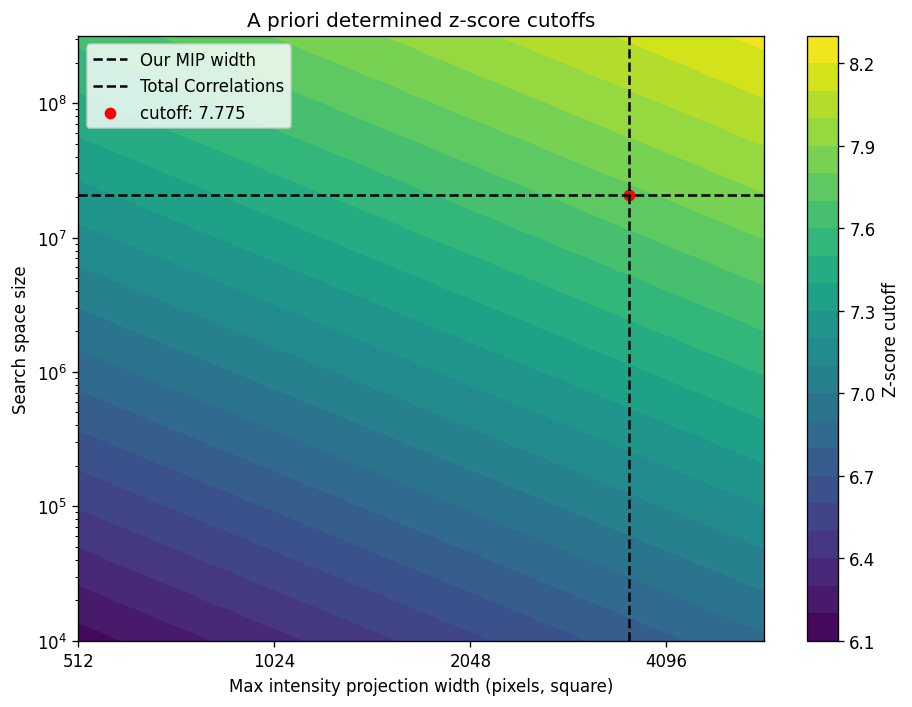

In [8]:
# Create grid of number of pixels and search space size
x = np.logspace(9, 12.5, num=32, base=2)  # Image width
y = np.logspace(4, 8.5, num=32, base=10)  # Search space size
xx, yy = np.meshgrid(x, y)

# Calculate z-score cutoff for each pixel
zscore_cutoffs = np.zeros_like(xx)
for i in range(xx.shape[0]):
    for j in range(xx.shape[1]):
        num_pixels = int(xx[i, j] ** 2)
        search_space_size = int(yy[i, j])
        zscore_cutoffs[i, j] = gaussian_noise_zscore_cutoff(
            num_ccg=num_pixels * search_space_size,
            false_positives=1.0,
        )

# Contour plot of z-score cutoff
plt.figure(figsize=(8, 6))
plt.contourf(xx, yy, zscore_cutoffs, levels=20, cmap="viridis")
plt.colorbar(label="Z-score cutoff")

# Lines corresponding to the results we are investigating
plt.axvline(x=mip.size**0.5, color="k", linestyle="--", label="Our MIP width")
plt.axhline(y=total_correlations, color="k", linestyle="--", label="Total Correlations")
plt.scatter(
    mip.size**0.5,
    total_correlations,
    color="red",
    marker="o",
    label=f"cutoff: {apr_zscore_cutoff:.3f}",
)

plt.xscale("log", base=2)
plt.xticks(
    ticks=[2**i for i in range(9, 13)],
    labels=[f"{int(2**i)}" for i in range(9, 13)],
)
plt.yscale("log", base=10)
plt.xlabel("Max intensity projection width (pixels, square)")
plt.ylabel("Search space size")
plt.title("A priori determined z-score cutoffs")
plt.legend()
plt.tight_layout()
plt.show()

We fill now extract peak positions with this cutoff.

In [12]:
zscore_cutoff = 7.775
pos_y_zscore, pos_x_zscore = find_peaks_from_zscore(torch.tensor(scaled_mip), zscore_cutoff, mask_radius=5)
#get number of peaks
num_peaks_zscore = len(pos_y_zscore)
print(f"Number of peaks found using z-score metric: {num_peaks_zscore}")


Number of peaks found using z-score metric: 198


## Fitted extreme value distribution

Since 2DTM records the maximum cross-correlation value over a large search space, the background noise is distributed as a generalized extreme value distribution.
We can fit our data to this distribution to capture slight deviations from idealized normal noise.
Like before, a cutoff value can be derived for a given number of false positives.

In [19]:
# Fit a generalized extreme value (GEV) distribution to the z-scores
# NOTE: this could take a while to run (1-3 mins), depending on the number of samples
gev_opt, (shape, loc, scale) = fit_gev_to_zscore(
    scaled_mip,
    num_samples=5_000_000,
    max_zscore_value=8.5,  # Prevent fitting to signal
)

In [20]:
gev_zscore_cutoff_val = gev_opt.isf(1 / mip.size)
print(f"GEV z-score cutoff: {gev_zscore_cutoff_val:.3f}")

GEV z-score cutoff: 7.757


Number of pixels above GEV cutoff (7.752): 1129


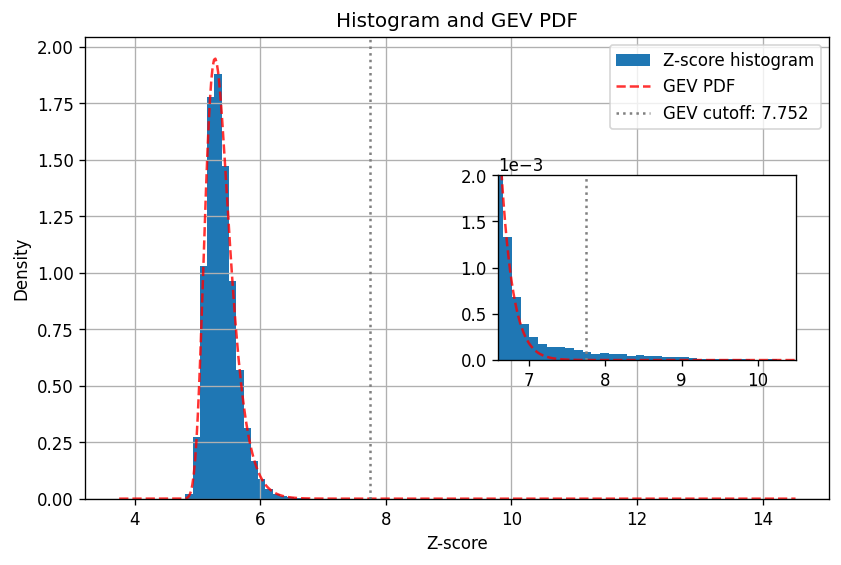

In [ ]:
# Create the main figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Plot the full histogram and fitted GEV PDF on the main axis
counts, bins, _ = ax.hist(
    scaled_mip.ravel(),
    bins=64,
    density=True,
    label="Z-score histogram",
)
x_vals = np.linspace(scaled_mip.min() * 0.8, scaled_mip.max() * 1.2, 500)
ax.plot(
    x_vals,
    gev_opt.pdf(x_vals),
    color="red",
    label="GEV PDF",
    linestyle="--",
    alpha=0.8,
)
ax.axvline(
    gev_zscore_cutoff_val,
    color="grey",
    linestyle=":",
    label=f"GEV cutoff: {gev_zscore_cutoff_val:.3f}",
)
ax.set_title("Histogram and GEV PDF")
ax.set_xlabel("Z-score")
ax.set_ylabel("Density")
ax.grid()

# Create an inset axis in the upper right corner (zoomed view)
axins = inset_axes(ax, width="40%", height="40%", loc="center right", borderpad=2)

axins.hist(scaled_mip.ravel(), bins=64, density=True)
axins.plot(x_vals, gev_opt.pdf(x_vals), color="red", linestyle="--", alpha=0.8)
axins.axvline(gev_zscore_cutoff_val, color="grey", linestyle=":")
axins.set_xlim(6.6, 10.5)
axins.set_ylim(0, 2e-3)  # Adjust y-limit as needed
axins.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))

ax.legend(loc="upper right")
plt.show()

And now we will extract peaks again with the GEV cutoff

In [21]:
zscore_cutoff = 7.757
pos_y_gev, pos_x_gev = find_peaks_from_zscore(torch.tensor(scaled_mip), zscore_cutoff, mask_radius=5)
#get number of peaks
num_peaks_gev = len(pos_y_gev)
print(f"Number of peaks found using GEV metric: {num_peaks_gev}")


Number of peaks found using GEV metric: 199


## Using the p-value metric

The p-value metric, described in (Zhang et al. (2025). A new statistical metric for robust target detection in cryo-EM using 2D template matching. IUCrJ, 12, 155-176.), fits a 2D Gaussian random variable to the probit transformed MIP and z-score map.
Each pair of MIP and z-scores can then be transformed into a probability value given this fitted 2D Gaussian.
Below, we step through this process but the Leopard-EM package performs all these steps automatically when given the MIP and z-score maps.

### Applying the probit transformation

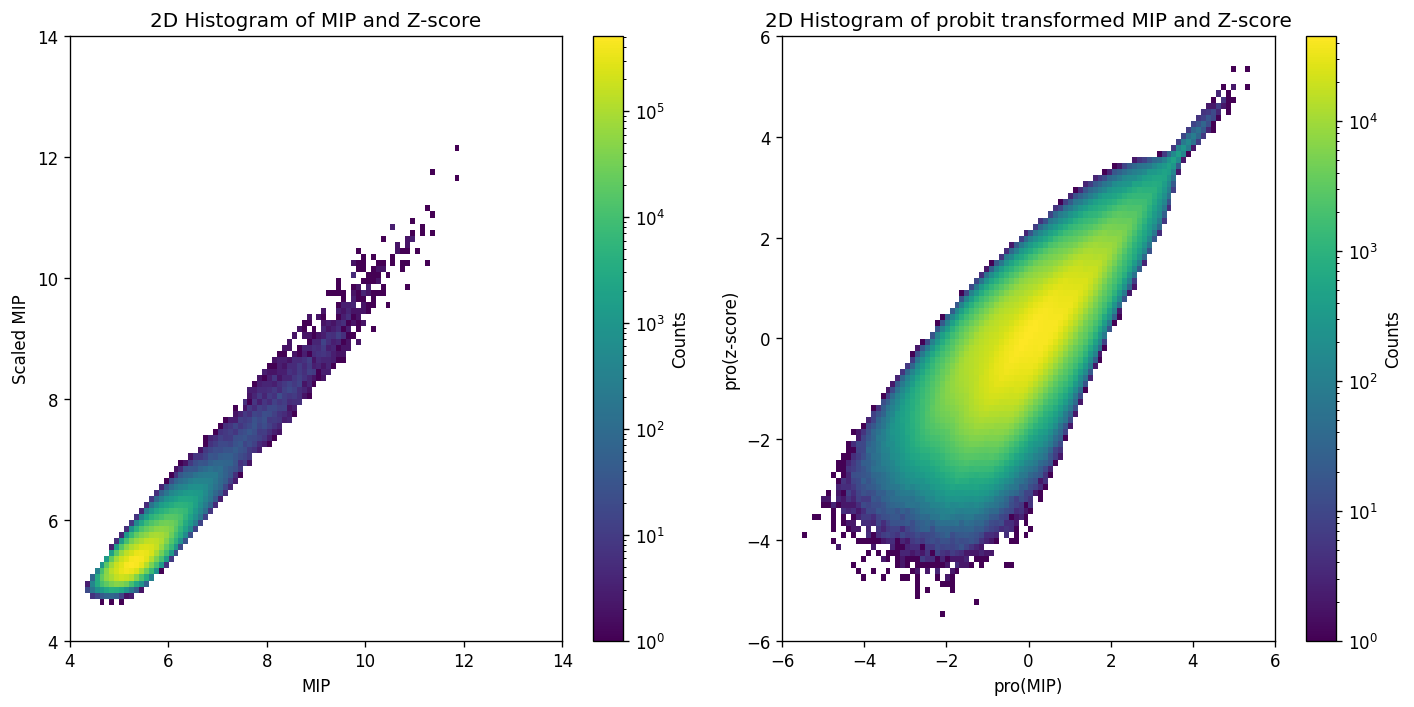

In [22]:
import torch
scaled_mip_probit = (
    probit_transform_torch(torch.from_numpy(scaled_mip).flatten())
    .cpu()
    .numpy()
)

mip_probit = (
    probit_transform_torch(torch.from_numpy(mip).flatten())
    .cpu()
    .numpy()
)

mip_flat = mip.ravel()
scaled_mip_flat = scaled_mip.ravel()

# 2D histogram of the flattened MIP and z-scores
hist, xedges, yedges = np.histogram2d(
    mip_flat,
    scaled_mip_flat,
    bins=100,
    range=[(4, 14), (4, 14)],
)

hist_probit, xedges_probit, yedges_probit = np.histogram2d(
    mip_probit,
    scaled_mip_probit,
    bins=100,
    range=[(-6, 6), (-6, 6)],
)

fig, ax = plt.subplots(1, 2, figsize=(12, 6))

# Plot the original histogram
c1 = ax[0].imshow(
    hist.T,
    origin="lower",
    extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]],
    aspect="auto",
    cmap="viridis",
    norm=mpl.colors.LogNorm(),
)
cbar1 = fig.colorbar(c1, ax=ax[0])
cbar1.set_label("Counts")
ax[0].set_title("2D Histogram of MIP and Z-score")
ax[0].set_xlabel("MIP")
ax[0].set_ylabel("Scaled MIP")

# Plot the probit-transformed histogram
c2 = ax[1].imshow(
    hist_probit.T,
    origin="lower",
    extent=[xedges_probit[0], xedges_probit[-1], yedges_probit[0], yedges_probit[-1]],
    aspect="auto",
    cmap="viridis",
    norm=mpl.colors.LogNorm(),
)
cbar2 = fig.colorbar(c2, ax=ax[1])
cbar2.set_label("Counts")
ax[1].set_title("2D Histogram of probit transformed MIP and Z-score")
ax[1].set_xlabel("pro(MIP)")
ax[1].set_ylabel("pro(z-score)")

plt.tight_layout()
plt.show()



### Fit 2D anisotropic Gaussian

/home/jdickerson/miniconda3/envs/leopard-em/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


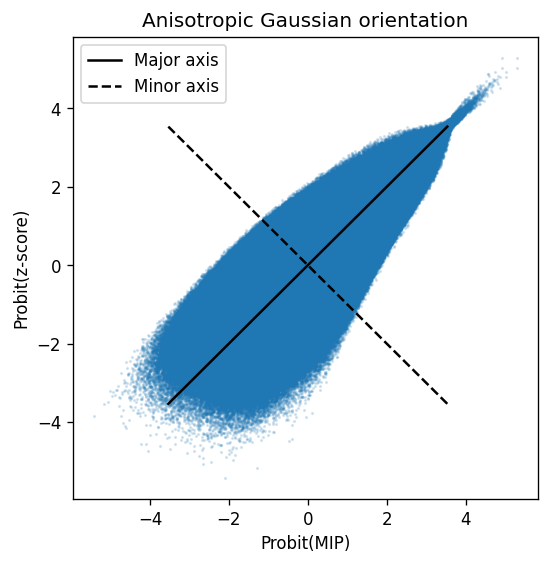

In [ ]:
d_inv, u_inv = estimate_anisotropic_gaussian(
    torch.from_numpy(scaled_mip_probit),
    torch.from_numpy(mip_probit),
)

a = np.sqrt(d_inv.max().item())
b = np.sqrt(d_inv.min().item())

# Major axis direction
vec = u_inv[:, d_inv.argmax()].cpu().numpy()
theta = np.arctan2(vec[1], vec[0])

t = np.linspace(-5, 5, 200)

plt.figure(figsize=(5, 5))
plt.scatter(mip_probit, scaled_mip_probit, s=1, alpha=0.15)

plt.plot(
    t * np.sin(theta),
    t * np.cos(theta),
    "k",
    label="Major axis",
)

plt.plot(
    t * np.cos(theta),
    -t * np.sin(theta),
    "k",
    linestyle="--",
    label="Minor axis",
)

plt.legend()
plt.xlabel("Probit(MIP)")
plt.ylabel("Probit(z-score)")
plt.title("Anisotropic Gaussian orientation")
plt.show()


### Use a quadrant mask
You can use a 1 or 3 quadrant mask to only calcualte p-values for data in the top 1 or 3 quadrants.

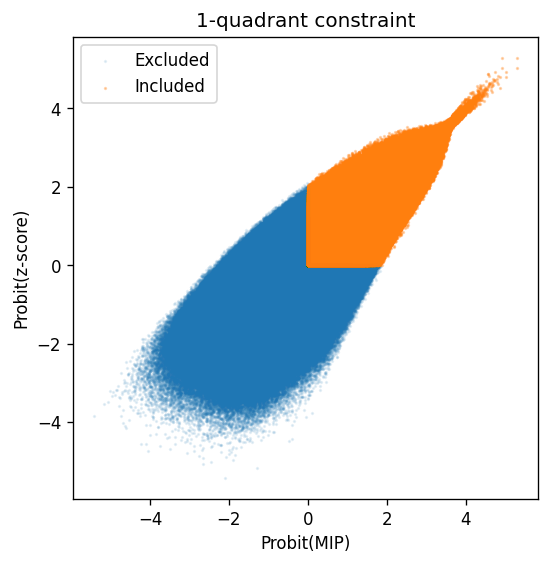

In [24]:
mask_1q = (scaled_mip_probit > 0) & (mip_probit > 0)

plt.figure(figsize=(5, 5))
plt.scatter(mip_probit[~mask_1q], scaled_mip_probit[~mask_1q], s=1, alpha=0.1, label="Excluded")
plt.scatter(mip_probit[mask_1q], scaled_mip_probit[mask_1q], s=1, alpha=0.3, label="Included")
plt.legend()
plt.xlabel("Probit(MIP)")
plt.ylabel("Probit(z-score)")
plt.title("1-quadrant constraint")
plt.show()


### Compute p-values

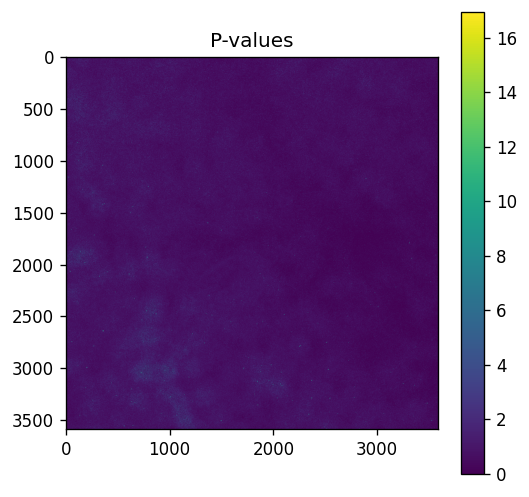

In [ ]:
# Compute p-values
neg_log_p = anisotropic_pvalue(
    torch.tensor(scaled_mip_probit), torch.tensor(mip_probit), d_inv, u_inv, quadrant=1
)

pvals = neg_log_p.reshape(mip.shape)

#plotting
plt.figure(figsize=(5, 5))
plt.imshow(pvals, cmap="viridis")
plt.colorbar()
plt.title("P-values")
plt.show()


### Finding peaks

We choose a cutoff of 8.9 for the p-value.
This cutoff is empircal, and should be adjusted to give the best results.
The advantage of the p-value is it may have a better true-positive:false-positive ratio than the simple z-scorefor a given number of peaks found.

In [44]:
# Select peaks
p_value_cutoff = 8.9
peaks = torch.nonzero(pvals > p_value_cutoff, as_tuple=False)
peak_vals = pvals[tuple(peaks.t())]

peaks = filter_peaks_by_distance(
    peak_values=peak_vals,
    peak_locations=peaks,
    distance_threshold=5,
)
pos_y_pvalue, pos_x_pvalue = peaks[:, 0], peaks[:, 1]
print(f"Number of peaks found using p-value metric with cutoff of {p_value_cutoff}: {len(pos_y_pvalue)}")


Number of peaks found using p-value metric with cutoff of 8.9: 197


## Comparison of all peaks

We can compare the detected peaks from the different methods.

/tmp/ipykernel_71094/1378621568.py:14: UserWarning: You passed a edgecolor/edgecolors ('darkblue') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pos_x_zscore, pos_y_zscore, s=50, alpha=0.6, c='blue', marker='x', label=f'Z-score ({len(pos_y_zscore)} peaks)', edgecolors='darkblue', linewidths=1)
/tmp/ipykernel_71094/1378621568.py:15: UserWarning: You passed a edgecolor/edgecolors ('darkred') for an unfilled marker ('+').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(pos_x_gev, pos_y_gev, s=50, alpha=0.6, c='red', marker='+', label=f'GEV ({len(pos_y_gev)} peaks)', edgecolors='darkred', linewidths=1)


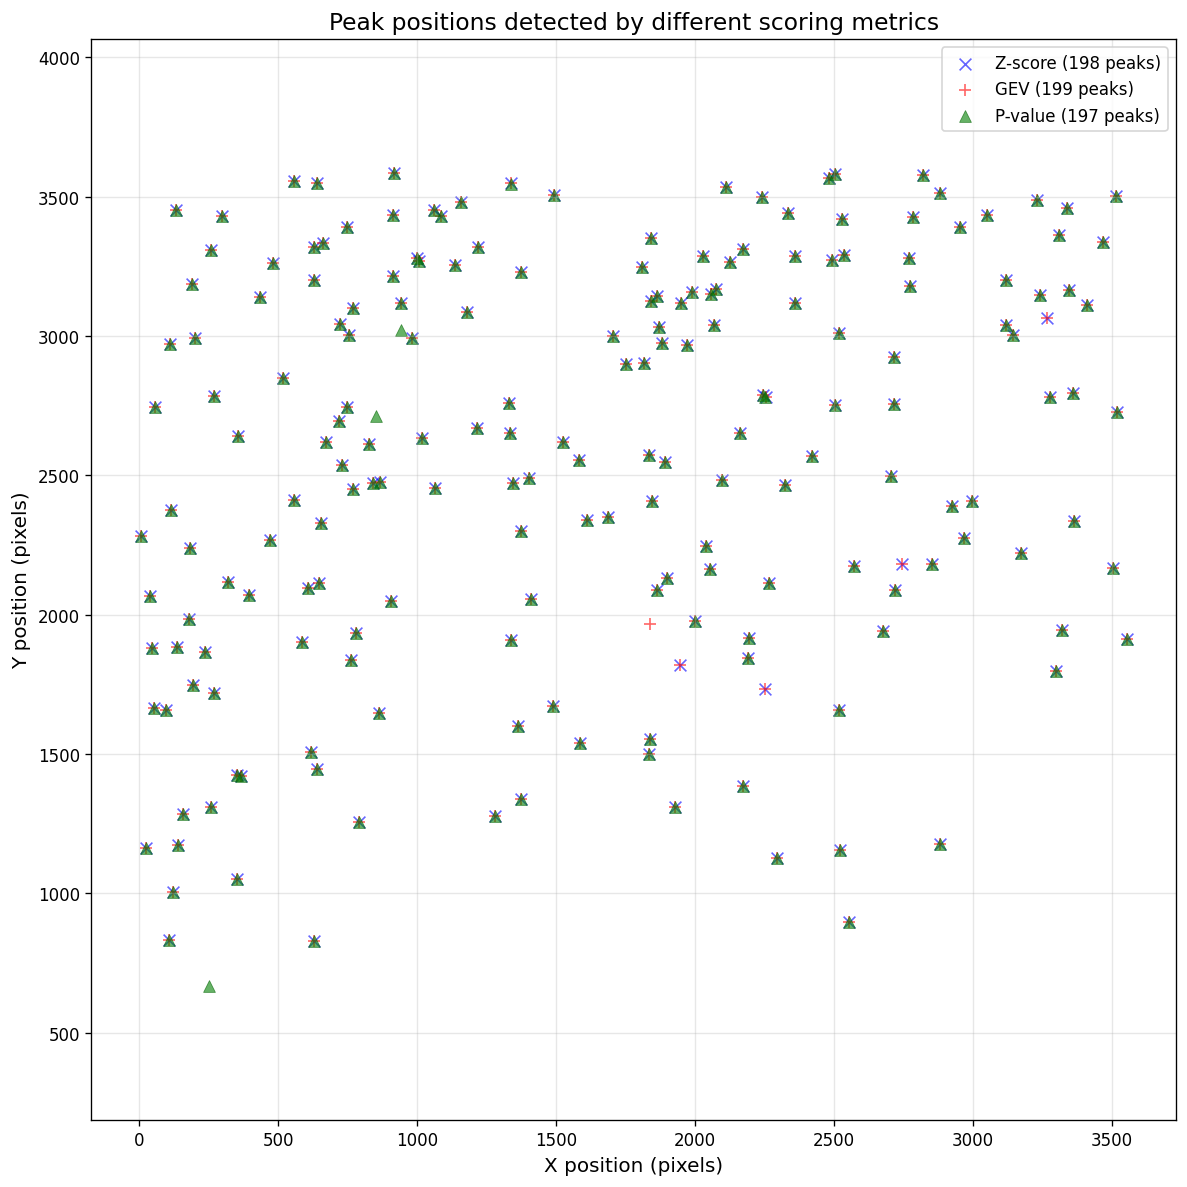


Overlap statistics:
Z-score peaks: 198
GEV peaks: 199
P-value peaks: 197

Peaks within 5.0 pixels:
Z-score & GEV: 198/198 (100.0%)
Z-score & P-value: 194/198 (98.0%)
GEV & P-value: 194/199 (97.5%)


In [51]:
# Convert to numpy for plotting if they're torch tensors
if isinstance(pos_y_zscore, torch.Tensor):
    pos_y_zscore = pos_y_zscore.cpu().numpy()
    pos_x_zscore = pos_x_zscore.cpu().numpy()
if isinstance(pos_y_gev, torch.Tensor):
    pos_y_gev = pos_y_gev.cpu().numpy()
    pos_x_gev = pos_x_gev.cpu().numpy()
if isinstance(pos_y_pvalue, torch.Tensor):
    pos_y_pvalue = pos_y_pvalue.cpu().numpy()
    pos_x_pvalue = pos_x_pvalue.cpu().numpy()

# Create the comparison plot
plt.figure(figsize=(10, 10))
plt.scatter(pos_x_zscore, pos_y_zscore, s=50, alpha=0.6, c='blue', marker='x', label=f'Z-score ({len(pos_y_zscore)} peaks)', edgecolors='darkblue', linewidths=1)
plt.scatter(pos_x_gev, pos_y_gev, s=50, alpha=0.6, c='red', marker='+', label=f'GEV ({len(pos_y_gev)} peaks)', edgecolors='darkred', linewidths=1)
plt.scatter(pos_x_pvalue, pos_y_pvalue, s=50, alpha=0.6, c='green', marker='^', label=f'P-value ({len(pos_y_pvalue)} peaks)', edgecolors='darkgreen', linewidths=0.5)

plt.xlabel('X position (pixels)', fontsize=12)
plt.ylabel('Y position (pixels)', fontsize=12)
plt.title('Peak positions detected by different scoring metrics', fontsize=14)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.axis('equal')
plt.tight_layout()
plt.show()

# Print overlap statistics
print(f"\nOverlap statistics:")
print(f"Z-score peaks: {len(pos_y_zscore)}")
print(f"GEV peaks: {len(pos_y_gev)}")
print(f"P-value peaks: {len(pos_y_pvalue)}")

# Calculate overlaps (peaks within 5 pixels of each other)
from scipy.spatial.distance import cdist

# Convert to arrays for distance calculation
zscore_points = np.column_stack([pos_x_zscore, pos_y_zscore])
gev_points = np.column_stack([pos_x_gev, pos_y_gev])
pvalue_points = np.column_stack([pos_x_pvalue, pos_y_pvalue])

# Find overlaps
zscore_gev_dist = cdist(zscore_points, gev_points)
zscore_pvalue_dist = cdist(zscore_points, pvalue_points)
gev_pvalue_dist = cdist(gev_points, pvalue_points)

overlap_threshold = 5.0  # pixels

zscore_gev_overlap = np.sum(np.min(zscore_gev_dist, axis=1) < overlap_threshold)
zscore_pvalue_overlap = np.sum(np.min(zscore_pvalue_dist, axis=1) < overlap_threshold)
gev_pvalue_overlap = np.sum(np.min(gev_pvalue_dist, axis=1) < overlap_threshold)

print(f"\nPeaks within {overlap_threshold} pixels:")
print(f"Z-score & GEV: {zscore_gev_overlap}/{len(pos_y_zscore)} ({100*zscore_gev_overlap/len(pos_y_zscore):.1f}%)")
print(f"Z-score & P-value: {zscore_pvalue_overlap}/{len(pos_y_zscore)} ({100*zscore_pvalue_overlap/len(pos_y_zscore):.1f}%)")
print(f"GEV & P-value: {gev_pvalue_overlap}/{len(pos_y_gev)} ({100*gev_pvalue_overlap/len(pos_y_gev):.1f}%)")


In [52]:
# Find peaks in p-value but not in z-score
from scipy.spatial.distance import cdist

# Convert to numpy arrays if needed
if isinstance(pos_y_zscore, torch.Tensor):
    pos_y_zscore = pos_y_zscore.cpu().numpy()
    pos_x_zscore = pos_x_zscore.cpu().numpy()
if isinstance(pos_y_pvalue, torch.Tensor):
    pos_y_pvalue = pos_y_pvalue.cpu().numpy()
    pos_x_pvalue = pos_x_pvalue.cpu().numpy()

# Convert to arrays for distance calculation
zscore_points = np.column_stack([pos_x_zscore, pos_y_zscore])
pvalue_points = np.column_stack([pos_x_pvalue, pos_y_pvalue])

# Find p-value peaks that are NOT close to any z-score peak (within 5 pixels)
overlap_threshold = 5.0
distances = cdist(pvalue_points, zscore_points)
min_distances = np.min(distances, axis=1)
pvalue_only_mask = min_distances >= overlap_threshold

# Get the peaks that are only in p-value
pvalue_only_y = pos_y_pvalue[pvalue_only_mask]
pvalue_only_x = pos_x_pvalue[pvalue_only_mask]

print(f"Peaks found by p-value method but NOT by z-score method: {len(pvalue_only_y)}")
print(f"\nZ-score and p-value for these peaks:")
print(f"{'Index':<8} {'Y':<8} {'X':<8} {'Z-score':<12} {'P-value':<12}")
print("-" * 50)

# Extract z-score and p-value for these peaks
for i, (y, x) in enumerate(zip(pvalue_only_y, pvalue_only_x)):
    y_idx, x_idx = int(y), int(x)
    zscore_val = scaled_mip[y_idx, x_idx]
    pvalue_val = pvals[y_idx, x_idx].item() if isinstance(pvals, torch.Tensor) else pvals[y_idx, x_idx]
    print(f"{i+1:<8} {y:<8.1f} {x:<8.1f} {zscore_val:<12.4f} {pvalue_val:<12.4f}")

# Summary statistics
if len(pvalue_only_y) > 0:
    zscore_vals = scaled_mip[pvalue_only_y.astype(int), pvalue_only_x.astype(int)]
    pvalue_vals = pvals[pvalue_only_y.astype(int), pvalue_only_x.astype(int)]
    if isinstance(pvalue_vals, torch.Tensor):
        pvalue_vals = pvalue_vals.cpu().numpy()
    
    print(f"\nSummary statistics for p-value-only peaks:")
    print(f"Z-score: min={zscore_vals.min():.4f}, max={zscore_vals.max():.4f}, mean={zscore_vals.mean():.4f}")
    print(f"P-value: min={pvalue_vals.min():.4f}, max={pvalue_vals.max():.4f}, mean={pvalue_vals.mean():.4f}")
    print(f"\nNote: These peaks have p-values above the cutoff but z-scores below the z-score cutoff")


Peaks found by p-value method but NOT by z-score method: 3

Z-score and p-value for these peaks:
Index    Y        X        Z-score      P-value     
--------------------------------------------------
1        2713.0   854.0    7.7256       9.1845      
2        669.0    250.0    7.7094       9.0422      
3        3022.0   944.0    7.4067       8.9045      

Summary statistics for p-value-only peaks:
Z-score: min=7.4067, max=7.7256, mean=7.6139
P-value: min=8.9045, max=9.1845, mean=9.0437

Note: These peaks have p-values above the cutoff but z-scores below the z-score cutoff
